In [13]:
import numpy as np
import matplotlib.pyplot as plt

In [14]:
# define parameters
N = 10

T_MAX = 3.0
T_MIN = 1.0
T_NUM = 21

EQ_STEPS = int(1E6)
AVG_STEPS = int(1E3)

T_arr = np.linspace(T_MAX, T_MIN, T_NUM)
E, M, C, X = np.zeros(T_NUM), np.zeros(T_NUM), np.zeros(T_NUM), np.zeros(T_NUM)
n1, n2 = 1.0 / (AVG_STEPS * N * N), 1.0 / (AVG_STEPS * AVG_STEPS * N * N)

In [15]:
# generate ising lattice
def lattice_init(N):
    lattice = 2 * np.random.randint(2, size=(N, N), dtype=int) - 1
    return lattice 

# Monte-Carlo move
def mcmove(lattice, T):
    for i in range(N):
        for j in range(N):
            x = np.random.randint(0, N)
            y = np.random.randint(0, N)
            # the sum of the neighbors spins
            neighbors_sum = lattice[(x + 1) % N, y] + lattice[x, (y + 1) % N] + lattice[(x - 1) % N, y] + lattice[x, (y - 1) % N]
            # delta energy
            dE = 2 * lattice[x, y] * neighbors_sum

            if (dE < 0 or np.random.rand() < np.exp(-dE / T)):
                lattice[x, y] *= -1
    return lattice 

# Calculate Energy
def calc_energy(lattice):
    E = 0
    for x in range(N):
        for y in range(N):
            neighbors_sum = lattice[(x + 1) % N, y] + lattice[x, (y + 1) % N] + lattice[(x - 1) % N, y] + lattice[x, (y - 1) % N]
            E += - neighbors_sum * lattice[x, y]
    return E / 2

# Calculate Magnetization
def calc_mag(lattice):
    return np.sum(lattice)

In [16]:
# init lattice
lattice = lattice_init(N)

for i, T in enumerate(T_arr):
    E1 = M1 = E2 = M2 = 0
    iT = 1.0 / T
    iT2 = iT * iT

    # equilibrate
    for step in range(EQ_STEPS):
        mcmove(lattice, T)

    # calculate the energy and magnetization
    for step in range(AVG_STEPS):
        mcmove(lattice, T)
        E = calc_energy(lattice)
        mag = calc_mag(lattice)

        E1 = E1 + E
        M1 = M1 + mag 
        M2 = M2 + mag * mag 
        E2 = E2 + E * E

    E[i] = n2 * E1
    M[i] = n1 * M1
    C[i] = (n1 * E2 - n2 * E1 * E1) * iT2
    X[i] = (n1 * M2 - n2 * M1 * M1) * iT

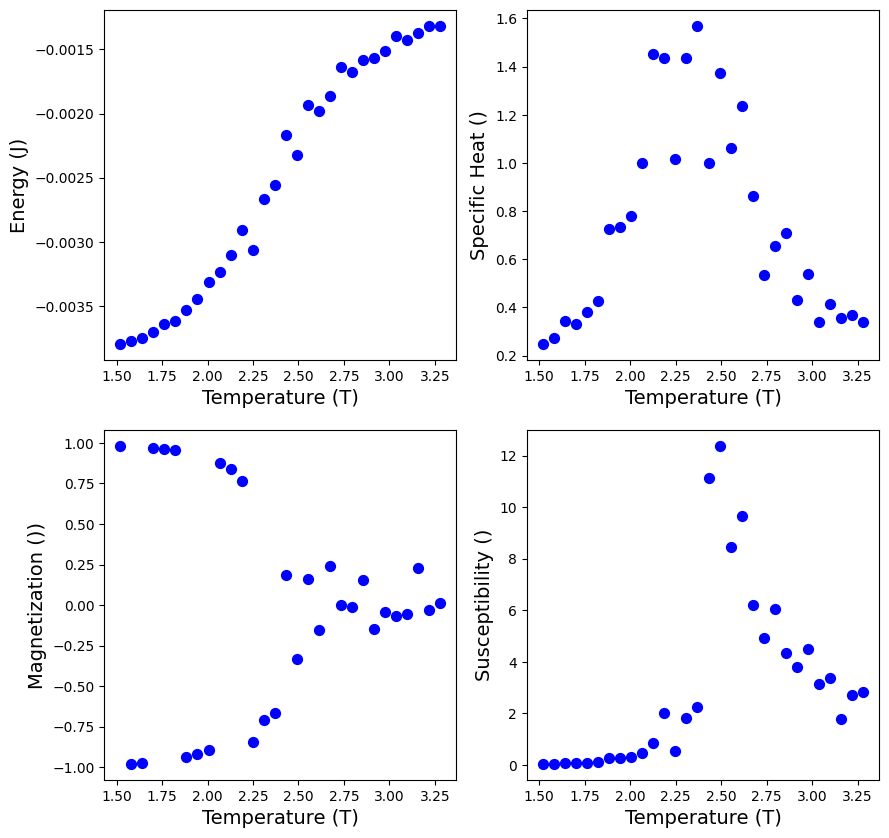

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))

ax[0, 0].scatter(T, E, s=50, marker='o', color='Blue');
ax[0, 0].set_xlabel('Temperature (T)', fontsize=14);
ax[0, 0].set_ylabel('Energy (J)', fontsize=14);

ax[1, 0].scatter(T, M, s=50, marker='o', color='Blue');
ax[1, 0].set_xlabel('Temperature (T)', fontsize=14);
ax[1, 0].set_ylabel('Magnetization ())', fontsize=14);

ax[0, 1].scatter(T, C, s=50, marker='o', color='Blue');
ax[0, 1].set_xlabel('Temperature (T)', fontsize=14);
ax[0, 1].set_ylabel('Specific Heat ()', fontsize=14);

ax[1, 1].scatter(T, X, s=50, marker='o', color='Blue');
ax[1, 1].set_xlabel('Temperature (T)', fontsize=14);
ax[1, 1].set_ylabel('Susceptibility ()', fontsize=14);

In [44]:
class Ising():

    def mcmove(self, config, N, beta):
        for i in range(N):
            for j in range(N):
                a = np.random.randint(0, N)
                b = np.random.randint(0, N)
                s = config[a, b]
                nb = config[(a + 1) % N, b] + config[a, (b+1) % N] + config[(a - 1) % N, b] + config[a, (b - 1) % N]
                cost = 2 * s * nb

                if cost < 0:
                    s *= -1
                elif np.random.rand() < np.exp(-cost * beta):
                    s *= -1
                config[a, b] = s
        return config

    def simulate(self):
        N, temp = 64, .4
        config = 2 * np.random.randint(2, size=(N, N)) - 1
        fig, ax = plt.subplots(2, 3, figsize=(15, 15));
        self.configPlot(ax, config, 0, N, (0, 0));

        msrmnt = 1001
        for i in range(msrmnt):
            self.mcmove(config, N, 1 / temp)
            if i == 1:
                self.configPlot(ax, config, i, N, (0, 1))
            if i == 4:
                self.configPlot(ax, config, i, N, (0, 2))
            if i == 32:
                self.configPlot(ax, config, i, N, (1, 0))
            if i == 100:
                self.configPlot(ax, config, i, N, (1, 1))
            if i == 1000:
                self.configPlot(ax, config, i, N, (1, 2))

    def configPlot(self, ax, config, i, N, n_):
        X, Y = np.meshgrid(range(N), range(N))
        ax[n_].axis('off')
        ax[n_].pcolormesh(X, Y, config, cmap=plt.cm.RdBu);
        ax[n_].set_title('Time=%d'%i);
        ax[n_].axis('tight')

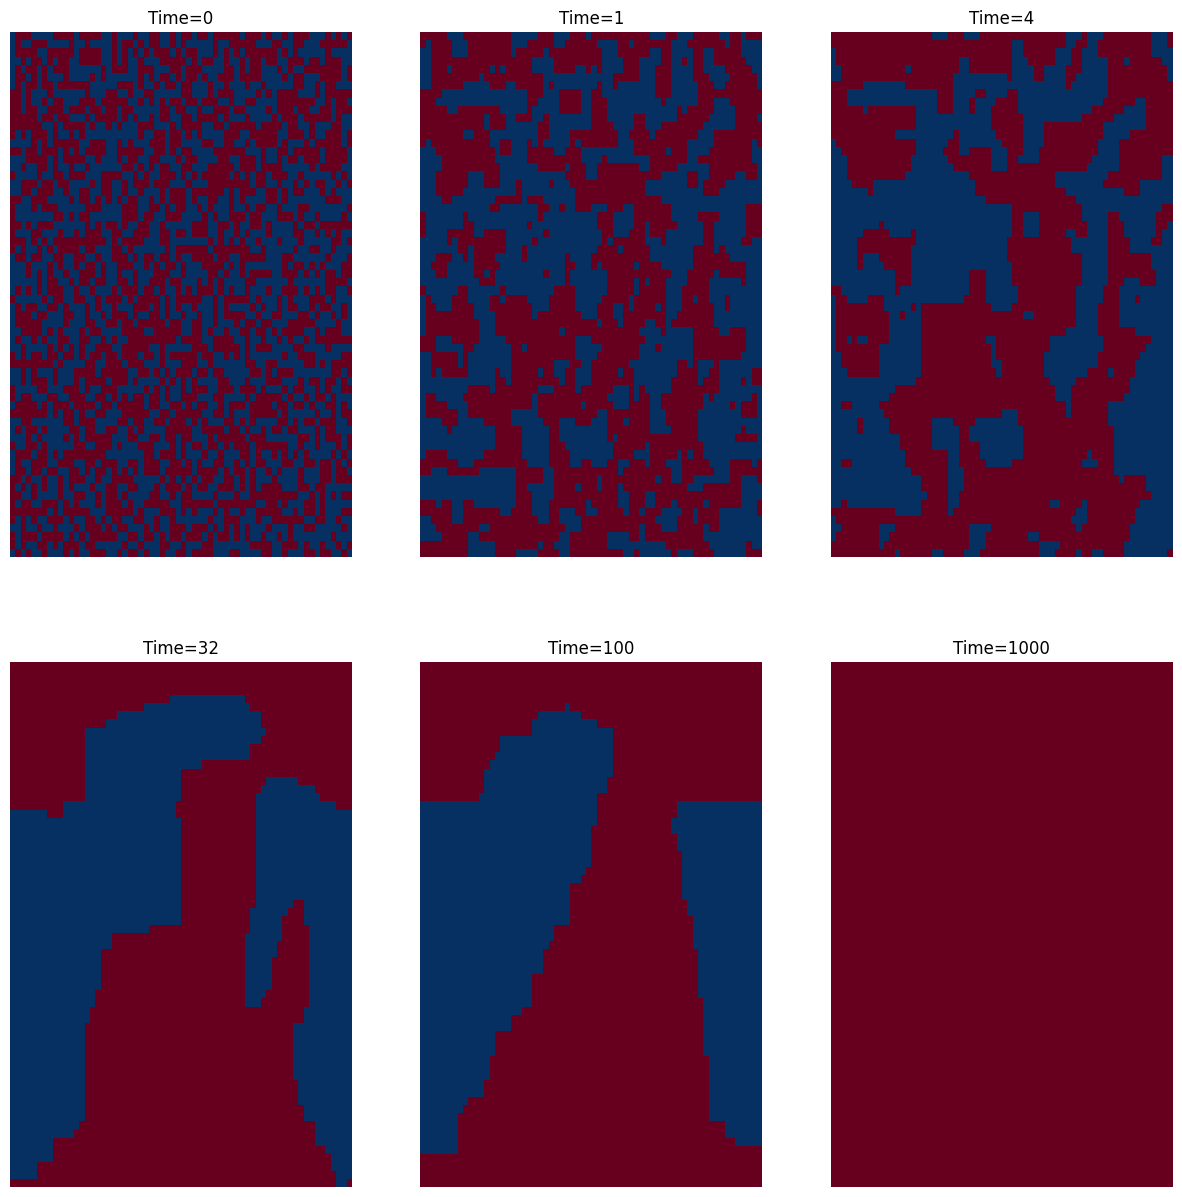

In [45]:
rm = Ising()
rm.simulate()

In [14]:
def init_lattice(n):

    '''Create a nxn lattice with random spin configuration'''
    
    lattice = np.random.choice([1, -1], size=(n, n))
    return lattice


def deltaE(S0, Sn, J, H):

    '''Energy difference for a spin flip'''
    
    return 2 * S0 * (H + J * Sn)


def ising(n=200, 
          nsteps=500000,
          H=0,
          J=1,
          T=1,
          count_spins = False,
          countij = [1,1],
          correlation=False,
          corr_ij=[0,0],
          corr_r=1):

    '''Ising Model Simulator. If count_spins = True, only flipping behavior of 1 site is studied.'''
    
    lattice = init_lattice(n)
    energy = 0
    energies = []
    spins = []
    spin = np.sum(lattice)
    icount, jcount = countij
    counted_spins = [lattice[icount, jcount]]
    counted_intervals = []
    icorr, jcorr = corr_ij
    Sis = []
    SiSjs = []
    
    for step in range(nsteps):

        i = np.random.randint(n)
        j = np.random.randint(n)

        # Periodic Boundary Condition
        Sn = lattice[(i - 1) % n, j] + lattice[(i + 1) % n, j] + \
             lattice[i, (j - 1) % n] + lattice[i, (j + 1) % n]

        dE = deltaE(lattice[i, j], Sn, J, H)

        if dE < 0 or np.random.random() < np.exp(-dE/T):
            lattice[i, j] = -lattice[i, j]
            energy += dE
            energies.append(energy)
         # Note that the spin is collected at every step
            spin += 2*lattice[i, j]
        
        if count_spins:
            ispin = lattice[icount, jcount]
            if ispin != counted_spins[-1]:
                counted_spins.append(ispin)
                counted_interval = step - sum(counted_intervals)

                counted_intervals.append(counted_interval)
        if correlation:
            Sn_corr = lattice[(icorr - corr_r) % n, jcorr] + lattice[(icorr + corr_r) % n, jcorr] + \
                      lattice[icorr, (jcorr - corr_r) % n] + lattice[icorr, (jcorr + corr_r) % n]
            Si = lattice[icorr, jcorr]
            SiSj = Si * Sn_corr / 4.0
            Sis.append(Si)
            SiSjs.append(SiSj)
            
        spins.append(spin)


    if correlation:
        return Sis, SiSjs
    
    if count_spins:
        return counted_spins, counted_intervals
        
    return lattice, energies, spins
    

def ising1000(n=1000, nsteps=10000000000, H=0, J=1, T=1):

    '''Ising Model Simulator. Special case for very large lattices.
    To reduce some memory usage:
    spin is added to the array every 1000 steps.
    Energies are not returned.
    Still pretty inefficient!
    '''
    
    lattice = init_lattice(n)
    energy = 0

    spins = []
    spin = np.sum(lattice)
    for istep, step in enumerate(xrange(nsteps)):

        i = np.random.randint(n)
        j = np.random.randint(n)

        # Periodic Boundary Condition
        Sn = lattice[(i - 1) % n, j] + lattice[(i + 1) % n, j] + \
             lattice[i, (j - 1) % n] + lattice[i, (j + 1) % n]

        dE = deltaE(lattice[i, j], Sn, J, H)

        if dE < 0 or np.random.random() < np.exp(-dE/T):
            lattice[i, j] = -lattice[i, j]
            energy += dE
            spin += 2*lattice[i, j]
        if istep % 1000 == 0:
            spins.append(spin)
    return lattice, spins


def write_job_script(wd='./', n=10, s=1000, i=1, T=1., nprocs=1, pe='smp', name = 'batch', q = 'long'):
    '''
    This is a function that writes a script to submit MC jobs
    '''
    py_file = '/afs/crc.nd.edu/user/p/pmehta1/ising-monte-carlo/spins.py'
    script='''#!/bin/bash
#$ -N {0}
#$ -pe {1} {2}
#$ -q {3}
#$ -cwd
'''.format(name, pe, nprocs, q)
       
    if nprocs > 1:
        cmd = 'mpirun -np $NSLOTS python'
        script+='{6} {5} -n {0} -s {1} -i {2} -t {3} -w {4}'.format(n, s, i, T, wd, py_file, cmd)

    else:
        script+='python {5} -n {0} -s {1} -i {2} -t {3} -w {4}'.format(n, s, i, T, wd, py_file)

    with open('{0}/qscript'.format(wd), 'w') as f:
        f.write(script)

def run_job(wd):
    '''
    Submit job to the queue
    '''
    import os
    from subprocess import Popen, PIPE
    cwd = os.getcwd()
    os.chdir(wd)
    p = Popen(['qsub', 'qscript'], stdout=PIPE, stderr=PIPE)
    out, err = p.communicate()
    
    if out == '' or err !='':
        raise Exception('something went wrong in qsub:\n\n{0}'.format(err))
    jobid = out.split()[2]
    f = open('jobid', 'w')
  
    f.write(jobid)
    f.close()
    os.chdir(cwd)
    return out.strip()    

In [58]:
for i in range(1):
    print(i)

0
